In [38]:
import asf_search as asf
import geopandas as gpd
from shapely.geometry import box
from shapely.ops import unary_union
from shapely import force_2d
from rasterio.crs import CRS
import pandas as pd
import yaml
from pathlib import Path
from tqdm import tqdm
import rasterio
import numpy as np
from asf_search import ASFSession
import http.cookiejar
from dem_stitcher.geojson_io import read_geojson_gzip
import backoff
from skimage.restoration import denoise_tv_bregman
import matplotlib.pyplot as plt

In [39]:
DAAC_ENV_CONFIG = {'GDAL_HTTP_UNSAFESSL': 'YES',
                   'GDAL_HTTP_COOKIEFILE': '~/cookies.txt',
                   'GDAL_HTTP_COOKIEJAR': '~/cookies.txt',
                   'GDAL_DISABLE_READDIR_ON_OPEN': 'YES',
                   'CPL_VSIL_CURL_ALLOWED_EXTENSIONS': 'TIF'}

# Load Event Data

In [40]:
yaml_file = 'events/chile_fire_2024.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'chile_fire_2024',
 'bounds': [-71.53071089, -33.20143816, -71.2964628, -32.98270579],
 'event_date': '2024-02-04',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [18, 156],
 'mgrs_tiles': ['19HBD'],
 'burst_ids': None,
 'links': ['https://earthobservatory.nasa.gov/images/152411/fires-rage-in-central-chile',
  'https://en.wikipedia.org/wiki/2024_Chile_wildfires']}

# Create Spatial AOI

In [41]:
aoi = box(*event_dict['bounds'])
df_aoi = gpd.GeoDataFrame(geometry=[aoi], crs=CRS.from_epsg(4326))

# Find MGRS tiles and Explore

In [42]:
df_mgrs = gpd.read_file('https://raw.githubusercontent.com/NASA-IMPACT/hls-land_tiles/master/s2_grid.json')
df_mgrs_overlapping = df_mgrs[df_mgrs.geometry.intersects(aoi)].reset_index(drop=True)
df_mgrs_overlapping.rename(columns={'identifier': 'tile_id'}, inplace=True)
# Remove extra column
df_mgrs_overlapping.drop(columns='type', inplace=True)
df_mgrs_overlapping['geometry'] = df_mgrs_overlapping.geometry.map(lambda multi_geo: unary_union(multi_geo.geoms))
# Makes 3d or Z dimension go away
df_mgrs_overlapping['geometry'] = df_mgrs_overlapping.geometry.map(lambda geo: force_2d(geo))
df_mgrs_overlapping.head()

,tile_id,geometry
0,19HBD,"POLYGON ((-72.19295 -32.49681, -71.02522 -32.5..."


In [43]:
m = df_mgrs_overlapping.explore(column='tile_id', categorical=True)
df_aoi.exterior.explore(m=m, style_kwds={'color':'black'})

# Select MGRS Tile(s)

In [44]:
MGRS_TILES = event_dict['mgrs_tiles']
BURST_IDS = event_dict['burst_ids']
BURST_IDS, MGRS_TILES

(None, ['19HBD'])

In [45]:
if BURST_IDS is None:
    df_mgrs_search = df_mgrs_overlapping[df_mgrs_overlapping.tile_id.isin(MGRS_TILES)].reset_index(drop=True)
    search_geo = df_mgrs_search.geometry.unary_union
else:
    df_all_bursts = read_geojson_gzip('../0_download_burst_data/opera_burst_ids.geojson.zip')
    df_burst = df_all_bursts[df_all_bursts.burst_id_jpl.isin([bid.lower() for bid in BURST_IDS])].reset_index(drop=True)
    search_geo = df_burst.geometry.unary_union.buffer(-5e-2)

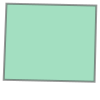

In [46]:
search_geo

# Explore Availability of RTC Data

In [47]:
import datetime
EVENT_DT = datetime.datetime.strptime(event_dict['event_date'], "%Y-%m-%d")
PRE_DT_START = EVENT_DT - datetime.timedelta(days=event_dict['pre_event_window_days'])
POST_DT_STOP = EVENT_DT + datetime.timedelta(days=event_dict['post_event_window_days'])


In [48]:
resp_pre = asf.geo_search(intersectsWith=search_geo.wkt,
                          processingLevel='RTC',
                          platform=asf.constants.SENTINEL1, 
                          start=PRE_DT_START, 
                          end=EVENT_DT)
len(resp_pre)

["'type': 'REVERSE': 'report': Reversed polygon winding order"]


375

In [49]:
resp_post = asf.geo_search(intersectsWith=search_geo.wkt,
                           processingLevel='RTC',
                           platform=asf.constants.SENTINEL1, 
                           start=EVENT_DT, 
                           end=POST_DT_STOP)
len(resp_post)

["'type': 'REVERSE': 'report': Reversed polygon winding order"]


254

In [50]:
df_rtc_resp_pre_e = gpd.GeoDataFrame.from_features(resp_pre.geojson(), crs=CRS.from_epsg(4326))
#df_rtc_resp_pre_e = df_rtc_resp_pre_e[df_rtc_resp_pre_e.pathNumber == 130].reset_index(drop=True)
df_rtc_resp_pre_e['geometry'] = df_rtc_resp_pre_e['geometry'].boundary
m = df_rtc_resp_pre_e.explore(alpha=.1, column='pathNumber', categorical=True, cmap='tab20c')
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)
m

In [15]:
df_rtc_resp_pre_e.pathNumber.unique()

array([156,  91,  83,  18])

In [16]:
df_rtc_resp_post_e = gpd.GeoDataFrame.from_features(resp_post.geojson(), crs=CRS.from_epsg(4326))
#df_rtc_resp_post_e = df_rtc_resp_post_e[df_rtc_resp_post_e.pathNumber == 130].reset_index(drop=True)
m = df_rtc_resp_post_e.explore()
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)

In [17]:
df_rtc_resp_post_e.head()

,geometry,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,...,validityStartDate,subswath,fileName,beamModeType,s3Urls,beamMode,additionalUrls,bistaticDelayCorrection,noiseCorrection,postProcessingFilter
0,"POLYGON ((-71.19107 -33.72822, -72.22363 -33.4...",-33.686367,-71.734989,2024-04-02T10:04:56Z,OPERA_L2_RTC-S1_T156-334210-IW2_20240402T10045...,DESCENDING,156,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-04-02T10:04:52Z,...,None,IW2,OPERA_L2_RTC-S1_T156-334210-IW2_20240402T10045...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
1,"POLYGON ((-72.07911 -33.40033, -72.97410 -33.1...",-33.371134,-72.554957,2024-04-02T10:04:54Z,OPERA_L2_RTC-S1_T156-334209-IW3_20240402T10045...,DESCENDING,156,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-04-02T10:04:51Z,...,None,IW3,OPERA_L2_RTC-S1_T156-334209-IW3_20240402T10045...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
2,"POLYGON ((-71.13709 -33.56423, -72.16763 -33.3...",-33.522527,-71.679852,2024-04-02T10:04:53Z,OPERA_L2_RTC-S1_T156-334209-IW2_20240402T10045...,DESCENDING,156,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-04-02T10:04:50Z,...,None,IW2,OPERA_L2_RTC-S1_T156-334209-IW2_20240402T10045...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
3,"POLYGON ((-70.27332 -33.70288, -71.25331 -33.4...",-33.671472,-70.790071,2024-04-02T10:04:52Z,OPERA_L2_RTC-S1_T156-334209-IW1_20240402T10044...,DESCENDING,156,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-04-02T10:04:49Z,...,None,IW1,OPERA_L2_RTC-S1_T156-334209-IW1_20240402T10044...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
4,"POLYGON ((-72.02340 -33.23666, -72.91677 -33.0...",-33.207702,-72.498333,2024-04-02T10:04:51Z,OPERA_L2_RTC-S1_T156-334208-IW3_20240402T10044...,DESCENDING,156,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-04-02T10:04:48Z,...,None,IW3,OPERA_L2_RTC-S1_T156-334208-IW3_20240402T10044...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE


# Select Track and Finalize Data Selection

In [18]:
if event_dict['burst_ids'] is not None:
    [bid.replace('_', '-').upper() for bid in event_dict['burst_ids']]

In [19]:
if MGRS_TILES is not None:
    
    resp = asf.geo_search(intersectsWith=search_geo.wkt,
                                 processingLevel='RTC',
                                 platform=asf.constants.SENTINEL1, 
                                 start=PRE_DT_START, 
                                 end=POST_DT_STOP,
                                 relativeOrbit=event_dict['rtc_track_numbers']
                                )
else:
    resp = asf.geo_search(processingLevel='RTC',
                                 platform=asf.constants.SENTINEL1, 
                                 start=PRE_DT_START, 
                                 end=POST_DT_STOP,
                                 operaBurstID=[bid.replace('-', '_').upper() for bid in event_dict['burst_ids']]
                                )
len(resp)

["'type': 'REVERSE': 'report': Reversed polygon winding order"]


585

In [20]:
df_rtc_resp = gpd.GeoDataFrame.from_features(resp.geojson(), crs=CRS.from_epsg(4326))
df_rtc_resp['acq_dt'] = pd.to_datetime(df_rtc_resp.startTime)
df_rtc_resp['acq_date'] = pd.to_datetime(df_rtc_resp.startTime).dt.round('D').dt.date

In [21]:
sorted(df_rtc_resp.acq_date.unique())

[datetime.date(2023, 11, 1),
 datetime.date(2023, 11, 10),
 datetime.date(2023, 11, 13),
 datetime.date(2023, 11, 22),
 datetime.date(2023, 11, 25),
 datetime.date(2023, 12, 4),
 datetime.date(2023, 12, 7),
 datetime.date(2023, 12, 16),
 datetime.date(2023, 12, 19),
 datetime.date(2023, 12, 28),
 datetime.date(2023, 12, 31),
 datetime.date(2024, 1, 9),
 datetime.date(2024, 1, 12),
 datetime.date(2024, 1, 21),
 datetime.date(2024, 1, 24),
 datetime.date(2024, 2, 2),
 datetime.date(2024, 2, 5),
 datetime.date(2024, 2, 14),
 datetime.date(2024, 2, 17),
 datetime.date(2024, 2, 26),
 datetime.date(2024, 2, 29),
 datetime.date(2024, 3, 9),
 datetime.date(2024, 3, 12),
 datetime.date(2024, 3, 21),
 datetime.date(2024, 3, 24),
 datetime.date(2024, 4, 2)]

<Axes: >

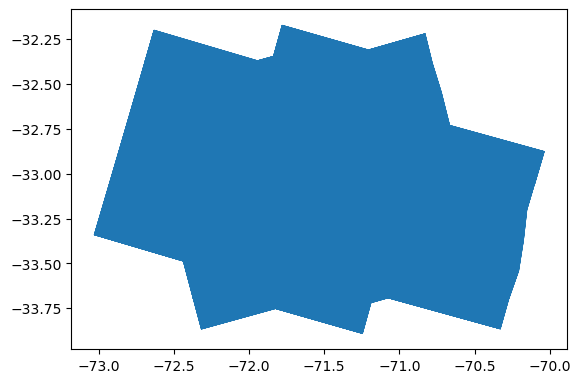

In [22]:
df_rtc_resp.plot()

# Save Data

In [23]:
burst_dir = Path('out') / event_dict['event_name'] / 'burst_data' 
burst_dir.mkdir(exist_ok=True, parents=True)
burst_dir

PosixPath('out/chile_fire_2024/burst_data')

In [24]:
from requests.exceptions import HTTPError
from mpire import WorkerPool
import scipy.ndimage as ndimage
from skimage.measure import regionprops, label

def despeckle_one(
    X: np.ndarray, reg_param=5, noise_floor_db=-22, preserve_nans=True
) -> np.ndarray:
    X_c = np.clip(X, 1e-7, 1)
    X_db = 10 * np.log10(X_c, out=np.full(X_c.shape, np.nan), where=(~np.isnan(X_c)))
    X_db[np.isnan(X_c)] = noise_floor_db
    X_db_dspkl = denoise_tv_bregman(
        X_db, weight=1.0 / reg_param, isotropic=True, eps=1e-3
    )
    X_dspkl = np.power(10, X_db_dspkl / 10.0)

    data_mask = np.isnan(X_c).astype(bool)
    mask_labels = label(data_mask)
    
    exterior_mask_val = mask_labels[0, 0]
    assert all([exterior_mask_val == mask_labels[i, j] for i in [0, -1] for j in [0, -1]])
    exterior_mask = (mask_labels == exterior_mask_val).astype(np.uint8)

    exterior_mask_b = ndimage.binary_dilation(exterior_mask, iterations=4).astype(bool)
    
    if preserve_nans:
        X_dspkl[exterior_mask_b] = np.nan
    else:
         X_dspkl[exterior_mask_b] = 0
    X_dspkl = np.clip(X_dspkl, 0, 1)
    
    return X_dspkl


def localize_one_rtc(
    url: str | Path | list | tuple,
    ts_dir: str | Path = Path("."),
    with_despeckling=False,
    preserve_nans=True,
) -> Path:
    if isinstance(url, (list, tuple)):
        local_fn = url[0].split("/")[-1]
        local_fn = f"{local_fn[:-7]}_stack.tif"
    else:
        local_fn = url.split("/")[-1]

    out_path = ts_dir / local_fn

    if out_path.exists():
        return out_path

    def open_one(url: str) -> tuple:
        with rasterio.Env(**DAAC_ENV_CONFIG):
            with rasterio.open(url) as ds:
                X = ds.read(1)
                p = ds.profile

        X = np.clip(X, 1e-7, 1)
        return X, p

    if not isinstance(url, (list, tuple)):
        arrs, ps = zip(*[open_one(url)])
    else:
        arrs, ps = zip(*list(map(open_one, url)))

    if with_despeckling:

        def despeckle_one_p(arr: np.ndarray) -> np.ndarray:
            return despeckle_one(arr, preserve_nans=preserve_nans)

        arrs = list(map(despeckle_one_p, arrs))

    X_out = np.stack(arrs, axis=0)
    p = ps[0].copy()
    p["count"] = X_out.shape[0]
    with rasterio.open(out_path, "w", **p) as ds:
        ds.write(X_out)
    return X_out

In [31]:
%%time


for (track_number, date), df_rtc_date in tqdm(df_rtc_resp.groupby(['pathNumber', 'acq_date']), desc='dates'):
    print(track_number, date, df_rtc_date.shape[0])
    vh_urls = df_rtc_date.url.tolist()
    vv_urls = [url.replace('VH.tif', 'VV.tif') for url in vh_urls]
    ts_dir = burst_dir / f'track{str(track_number)}' / f'{str(date)}'
    ts_dir.mkdir(exist_ok=True, parents=True)
    localize_one_rtc_p = lambda url: localize_one_rtc(url, ts_dir=ts_dir)

    with WorkerPool(n_jobs=5, use_dill=True) as pool:
        dual_loc_path = pool.map(
            localize_one_rtc_p,
            vv_urls + vh_urls,
            progress_bar=True,\
            progress_bar_style="std",
            concatenate_numpy_output=False,
        )


dates:   0%|                                            | 0/26 [00:00<?, ?it/s]

18 2023-11-01 16


dates:   4%|█▍                                  | 1/26 [00:00<00:07,  3.44it/s]

18 2023-11-13 16


dates:   8%|██▊                                 | 2/26 [00:00<00:06,  3.82it/s]

18 2023-11-25 16


dates:  12%|████▏                               | 3/26 [00:00<00:05,  3.89it/s]

18 2023-12-07 16


dates:  15%|█████▌                              | 4/26 [00:01<00:05,  3.91it/s]

18 2023-12-19 16


dates:  19%|██████▉                             | 5/26 [00:01<00:05,  3.95it/s]

18 2023-12-31 16


dates:  23%|████████▎                           | 6/26 [00:01<00:04,  4.07it/s]

18 2024-01-12 16


dates:  27%|█████████▋                          | 7/26 [00:01<00:04,  4.13it/s]

18 2024-01-24 16


dates:  31%|███████████                         | 8/26 [00:02<00:04,  4.04it/s]

18 2024-02-05 16


dates:  35%|████████████▍                       | 9/26 [00:02<00:04,  3.97it/s]

18 2024-02-17 16


dates:  38%|█████████████▍                     | 10/26 [00:02<00:04,  3.92it/s]

18 2024-02-29 32


dates:  42%|██████████████▊                    | 11/26 [00:02<00:03,  3.89it/s]

18 2024-03-12 29


dates:  46%|████████████████▏                  | 12/26 [00:03<00:03,  3.88it/s]

18 2024-03-24 16


dates:  50%|█████████████████▌                 | 13/26 [00:03<00:03,  3.85it/s]

156 2023-11-10 22


dates:  54%|██████████████████▊                | 14/26 [00:03<00:03,  3.85it/s]

156 2023-11-22 22


dates:  58%|████████████████████▏              | 15/26 [00:03<00:02,  3.87it/s]

156 2023-12-04 44


dates:  62%|█████████████████████▌             | 16/26 [00:04<00:02,  3.86it/s]

156 2023-12-16 44


dates:  65%|██████████████████████▉            | 17/26 [00:04<00:02,  3.85it/s]

156 2023-12-28 22


dates:  69%|████████████████████████▏          | 18/26 [00:04<00:02,  3.86it/s]

156 2024-01-09 22


dates:  73%|█████████████████████████▌         | 19/26 [00:04<00:01,  3.89it/s]

156 2024-01-21 22


dates:  77%|██████████████████████████▉        | 20/26 [00:52<01:27, 14.59s/it]

156 2024-02-02 22


dates:  81%|████████████████████████████▎      | 21/26 [01:38<02:00, 24.06s/it]

156 2024-02-14 44


dates:  85%|█████████████████████████████▌     | 22/26 [03:07<02:54, 43.52s/it]

156 2024-02-26 13


dates:  88%|██████████████████████████████▉    | 23/26 [03:38<01:58, 39.53s/it]

156 2024-03-09 27


dates:  92%|████████████████████████████████▎  | 24/26 [04:32<01:27, 43.91s/it]

156 2024-03-21 22


dates:  96%|█████████████████████████████████▋ | 25/26 [05:18<00:44, 44.52s/it]

156 2024-04-02 22


dates: 100%|███████████████████████████████████| 26/26 [06:07<00:00, 14.12s/it]

CPU times: user 3.87 s, sys: 4.21 s, total: 8.09 s
Wall time: 6min 7s


# Merge data

In [32]:
track_dirs = [burst_dir / f'track{t}' for t in event_dict["rtc_track_numbers"]] #list(RTC_PRE_DIR.glob('*'))
acq_dirs = sorted([date_dir for track_dir in track_dirs for date_dir in track_dir.glob('*/')])
acq_dirs

[PosixPath('out/chile_fire_2024/burst_data/track156/2023-11-10'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2023-11-22'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2023-12-04'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2023-12-16'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2023-12-28'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2024-01-09'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2024-01-21'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2024-02-02'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2024-02-14'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2024-02-26'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2024-03-09'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2024-03-21'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2024-04-02'),
 PosixPath('out/chile_fire_2024/burst_data/track18/2023-11-01'),
 PosixPath('out/chile_fire_2024/burst_data/track18/2023-11-13'),
 PosixPath('

In [33]:
from rasterio.merge import merge
def merge_one_dir(acq_dir: Path, pol='VV', preserve_nans=True) -> list:
    assert pol in ['VV', 'VH']
    all_img_paths = list(acq_dir.glob(f'OPERA*{pol}.tif'))
    acq_date_track = f'{acq_dir.parent.stem}_{acq_dir.stem}'
    dst_path = acq_dir / f'__{acq_date_track}_merged_{pol}.tif'
    
    if dst_path.exists():
        return dst_path
        
    X_m, t_m = merge(all_img_paths, dtype='float32', method='first')
    with rasterio.open(all_img_paths[0]) as ds:
        p = ds.profile
    prof_merged = p.copy()
    prof_merged['transform'] = t_m
    prof_merged['count'] = X_m.shape[0]
    prof_merged['height'] = X_m.shape[1]
    prof_merged['width'] = X_m.shape[2]

    X_m_d = despeckle_one(X_m[0, ...], preserve_nans=preserve_nans)
    with rasterio.open(dst_path, 'w', **prof_merged) as ds:
        ds.write(X_m_d, 1)
    
    return dst_path

In [34]:
dst_paths = [merge_one_dir(directory, pol=pol) for directory in tqdm(acq_dirs[:]) for pol in ['VV', 'VH']]
dst_paths

100%|██████████████████████████████████████████| 26/26 [07:21<00:00, 16.99s/it]


[PosixPath('out/chile_fire_2024/burst_data/track156/2023-11-10/__track156_2023-11-10_merged_VV.tif'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2023-11-10/__track156_2023-11-10_merged_VH.tif'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2023-11-22/__track156_2023-11-22_merged_VV.tif'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2023-11-22/__track156_2023-11-22_merged_VH.tif'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2023-12-04/__track156_2023-12-04_merged_VV.tif'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2023-12-04/__track156_2023-12-04_merged_VH.tif'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2023-12-16/__track156_2023-12-16_merged_VV.tif'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2023-12-16/__track156_2023-12-16_merged_VH.tif'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2023-12-28/__track156_2023-12-28_merged_VV.tif'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2023-12-28/__track156_2023-12-

# Final Time Series

In [35]:
track_numbers = [p.stem.split('_')[2] for p in dst_paths]
dst_paths_grouped_by_track = {t: [p for p in dst_paths if t in p.stem] for t in track_numbers}
dst_paths_grouped_by_track

{'track156': [PosixPath('out/chile_fire_2024/burst_data/track156/2023-11-10/__track156_2023-11-10_merged_VV.tif'),
  PosixPath('out/chile_fire_2024/burst_data/track156/2023-11-10/__track156_2023-11-10_merged_VH.tif'),
  PosixPath('out/chile_fire_2024/burst_data/track156/2023-11-22/__track156_2023-11-22_merged_VV.tif'),
  PosixPath('out/chile_fire_2024/burst_data/track156/2023-11-22/__track156_2023-11-22_merged_VH.tif'),
  PosixPath('out/chile_fire_2024/burst_data/track156/2023-12-04/__track156_2023-12-04_merged_VV.tif'),
  PosixPath('out/chile_fire_2024/burst_data/track156/2023-12-04/__track156_2023-12-04_merged_VH.tif'),
  PosixPath('out/chile_fire_2024/burst_data/track156/2023-12-16/__track156_2023-12-16_merged_VV.tif'),
  PosixPath('out/chile_fire_2024/burst_data/track156/2023-12-16/__track156_2023-12-16_merged_VH.tif'),
  PosixPath('out/chile_fire_2024/burst_data/track156/2023-12-28/__track156_2023-12-28_merged_VV.tif'),
  PosixPath('out/chile_fire_2024/burst_data/track156/2023-12-

In [36]:
import shutil
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
from dem_stitcher.rio_window import get_indices_from_extent
from rasterio.warp import transform_bounds
from rasterio.transform import xy
from affine import Affine

def get_idx_with_largest_size(paths: list[Path]) -> int:
    def get_size(path: Path) -> int:
        with rasterio.open(path) as ds:
            m, n = ds.shape

        return m * n

    sizes = list(map(get_size, paths))
    idx = np.argmax(sizes)
    return idx

def get_cropped_profile(profile: dict,
                        slice_x: slice,
                        slice_y: slice) -> dict:
    """
    This is a tool for using a reference profile and numpy slices (i.e.
    np.s_[start: stop]) to create a new profile that is within the window of
    slice_x, slice_y.

    Parameters
    ----------
    profile : dict
        The reference rasterio profile.
    slice_x : slice
        The horizontal slice.
    slice_y : slice
        The vertical slice.

    Returns
    -------
    dict:
        The rasterio dictionary from cropping.
    """


    x_start = slice_x.start or 0
    y_start = slice_y.start or 0
    x_stop = slice_x.stop or profile['width']
    y_stop = slice_y.stop or profile['height']

    if (x_start < 0) | (x_stop < 0) | (y_start < 0) | (y_stop < 0):
        raise ValueError('Slices must be positive')

    width = x_stop - x_start
    height = y_stop - y_start

    profile_cropped = profile.copy()

    trans = profile['transform']
    x_cropped, y_cropped = xy(trans, y_start, x_start, offset='ul')
    trans_list = list(trans.to_gdal())
    trans_list[0] = x_cropped
    trans_list[3] = y_cropped
    tranform_cropped = Affine.from_gdal(*trans_list)
    profile_cropped['transform'] = tranform_cropped

    profile_cropped['height'] = height
    profile_cropped['width'] = width

    return profile_cropped

def make_cube(paths: list[Path]):
    track_number = paths[0].stem.split('_')[2]
    date = paths[0].stem.split('_')[3]

    ts_dir = burst_dir.parent / 'rtc_ts_merged' / track_number 
    ts_dir.mkdir(exist_ok=True, parents=True)
    
    ref_idx = get_idx_with_largest_size(paths)

    def get_profile(path: Path) -> dict:
        with rasterio.open(path) as ds:
            p = ds.profile
        return p

    profiles = list(map(get_profile, paths))
    ref_profile = profiles[ref_idx]

    cube_paths = []
    for p, path in zip(profiles, paths):
        out_path = ts_dir / path.name
        cond0 = (p['transform'] == ref_profile['transform'])
        cond1 = (p['width'] == ref_profile['width'])
        cond2 = (p['height'] == ref_profile['height'])
        cond3 = (p['crs'] == ref_profile['crs'])
            
        with rasterio.open(path) as ds:
            X_r = ds.read(1)
            p = ds.profile
            src_shape = ds.shape
        p_r = p.copy()
        if not (cond0 and cond1 and cond2 and cond3):
            X_r, p_r = reproject_arr_to_match_profile(X_r, p, ref_profile)
            X_r = X_r[0, ...]

        src_crs = p_r['crs']
        src_shape = X_r.shape
        src_transform = p_r['transform']
        extent_r = transform_bounds(CRS.from_epsg(4326), src_crs, *search_geo.bounds)

        corner_ul, corner_br = get_indices_from_extent(src_transform, extent_r, shape=src_shape, res_buffer=0)
        row_start, col_start = corner_ul
        row_stop, col_stop = corner_br
        sy = np.s_[row_start: row_stop]
        sx = np.s_[col_start: col_stop]

        p_c = get_cropped_profile(p_r, sx, sy)
        X_c = X_r[sy, sx]
        
        with rasterio.open(out_path, 'w', **p_c) as ds:
            ds.write(X_c, 1)
        cube_paths.append(out_path)
    return cube_paths

In [37]:
for paths_by_track in tqdm(dst_paths_grouped_by_track.values()):
    make_cube(paths_by_track)

100%|████████████████████████████████████████████| 2/2 [00:55<00:00, 27.80s/it]
